<a href="https://colab.research.google.com/github/Bluedata-Consulting/GAAPB01-training-code-base/blob/main/SELFLEARNING_LangChain_Chains_Routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chains - Routing

# How to route between sub-chains

:::info Prerequisites

This guide assumes familiarity with the following concepts:
- [LangChain Expression Language (LCEL)](/docs/concepts/#langchain-expression-language)
- [Chaining runnables](/docs/how_to/sequence/)
- [Configuring chain parameters at runtime](/docs/how_to/configure)
- [Prompt templates](/docs/concepts/#prompt-templates)
- [Chat Messages](/docs/concepts/#message-types)

:::

Routing allows you to create non-deterministic chains where the output of a previous step defines the next step. Routing can help provide structure and consistency around interactions with models by allowing you to define states and use information related to those states as context to model calls.

There are two ways to perform routing:

1. Conditionally return runnables from a [`RunnableLambda`](/docs/how_to/functions) (recommended)
2. Using a `RunnableBranch` (legacy)

We'll illustrate both methods using a two step sequence where the first step classifies an input question as being about `LangChain`, `Anthropic`, or `Other`, then routes to a corresponding prompt chain.

## Example Setup
First, let's create a chain that will identify incoming questions as being about `LangChain`, `Anthropic`, or `Other`:

In [3]:
model_name='gpt4o'

In [4]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate


from langchain.chat_models import init_chat_model
model = init_chat_model(model_name, model_provider="azure_openai")

chain = (
    PromptTemplate.from_template(
        """Given the user question below, classify it as either being about `LangChain`, `Gemini`, or `Other`.

Do not respond with more than one word.

<question>
{question}
</question>

Classification:"""
    )
    | model
    | StrOutputParser()
)

chain.invoke({"question": "how do I call Gemini?"})

'Gemini'

In [5]:
chain.invoke({"question": "how do I use LangChain?"})

'LangChain'

In [6]:
chain.invoke({"question": "what are the models available with OpenAI API?"})

'Other'

Now, let's create three sub chains:

In [7]:
langchain_chain = PromptTemplate.from_template(
    """You are an expert in langchain. \
Always answer questions starting with "As Harrison Chase told me". \
Respond to the following question:

Question: {question}
Answer:"""
) | model



gemini_chain = PromptTemplate.from_template(
    """You are an expert in Vertex AI Gemini Models. \
Always answer questions starting with "As Sundar Pichai told me". \
Respond to the following question:

Question: {question}
Answer:"""
) | model


general_chain = PromptTemplate.from_template(
    """Respond to the following question:

Question: {question}
Answer:"""
) | model

## Using a custom function (Recommended)

You can also use a custom function to route between different outputs. Here's an example:

In [8]:
def route(info):
    if "gemini" in info["topic"].lower():
        return gemini_chain
    elif "langchain" in info["topic"].lower():
        return langchain_chain
    else:
        return general_chain

In [9]:
from langchain_core.runnables import RunnableLambda

full_chain = {"topic": chain, "question": lambda x: x["question"]} | RunnableLambda(
    route
)

In [10]:
full_chain.invoke({"question": "how do I use Gemini?"})

AIMessage(content="As Sundar Pichai told me, using Gemini involves a few key steps. First, you'll want to access the Vertex AI platform through the Google Cloud console. Once you're there, you can create a new project or select an existing one.\n\nNext, you can choose the specific Gemini model that fits your needs, whether it's for text generation, image processing, or other AI tasks. You'll need to set up your environment, which includes configuring the necessary APIs and permissions.\n\nAfter that, you can start experimenting with the model by feeding it data and observing the outputs. The platform also offers tools for fine-tuning the models based on your specific use cases, along with detailed documentation and support to help you get the most out of Gemini.\n\nRemember to monitor your usage and optimize your model configurations as you go along to ensure efficient performance. Happy experimenting!", response_metadata={'token_usage': {'completion_tokens': 170, 'prompt_tokens': 48, 

In [11]:
full_chain.invoke({"question": "how do I use LangChain?"})

AIMessage(content="As Harrison Chase told me, using LangChain involves several key steps to effectively harness its capabilities. First, you need to install the LangChain library via pip. Once installed, you can start by setting up your environment, which may include configuring any necessary API keys for the language models you plan to use.\n\nNext, you'll want to define your chain components, which can include various models, tools, or memory elements depending on your application's needs. LangChain allows you to create different types of chains, such as LLM chains, simple sequential chains, or more complex multi-step chains.\n\nAfter defining your components, you can execute the chain to process your input and obtain the desired output. Throughout this process, you can also leverage built-in tools for handling prompts, managing memory, and integrating with external APIs or data sources.\n\nLastly, it's beneficial to explore the extensive documentation and examples provided by LangCh

In [12]:
full_chain.invoke({"question": "whats 2 + 2"})

AIMessage(content='2 + 2 equals 4.', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 24, 'total_tokens': 33, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected

## Using a RunnableBranch

A `RunnableBranch` is a special type of runnable that allows you to define a set of conditions and runnables to execute based on the input. It does **not** offer anything that you can't achieve in a custom function as described above, so we recommend using a custom function instead.

A `RunnableBranch` is initialized with a list of (condition, runnable) pairs and a default runnable. It selects which branch by passing each condition the input it's invoked with. It selects the first condition to evaluate to True, and runs the corresponding runnable to that condition with the input.

If no provided conditions match, it runs the default runnable.

Here's an example of what it looks like in action:

In [13]:
from langchain_core.runnables import RunnableBranch

branch = RunnableBranch(
    (lambda x: "gemini" in x["topic"].lower(), gemini_chain),
    (lambda x: "langchain" in x["topic"].lower(), langchain_chain),
    general_chain,
)
full_chain = {"topic": chain, "question": lambda x: x["question"]} | branch
full_chain.invoke({"question": "how do I use Gemini?"})

AIMessage(content="As Sundar Pichai told me, to use Gemini, you should start by accessing the Google Cloud Platform and navigating to the Vertex AI section. From there, you can set up your environment, choose the appropriate Gemini model for your specific use case, and utilize the provided APIs to integrate it into your applications. Be sure to refer to the detailed documentation for examples and best practices tailored to your needs. Additionally, exploring the user interface can help you fine-tune parameters and evaluate the model's performance effectively.", response_metadata={'token_usage': {'completion_tokens': 103, 'prompt_tokens': 48, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'prompt_filter_results': [{'prompt_index': 0

In [14]:
full_chain.invoke({"question": "how do I use LangChain?"})

AIMessage(content='As Harrison Chase told me, using LangChain involves several key steps to help you build applications that leverage language models effectively. Here’s a concise guide to get you started:\n\n1. **Installation**: First, you need to install the LangChain library. You can do this using pip:\n   ```bash\n   pip install langchain\n   ```\n\n2. **Set Up Your Environment**: Make sure you have access to a language model, whether it\'s OpenAI\'s GPT, Hugging Face models, or others. You\'ll also want to configure your API keys if required.\n\n3. **Import Necessary Modules**: Start by importing the components you need from LangChain. This may include models, chains, or tools depending on your application.\n\n4. **Initialize the Model**: Create an instance of the language model you want to use. For example, if you\'re using OpenAI’s GPT model:\n   ```python\n   from langchain.llms import OpenAI\n   llm = OpenAI(api_key="your_api_key")\n   ```\n\n5. **Create Chains**: Chains are s

In [15]:
full_chain.invoke({"question": "whats 2 + 2"})

AIMessage(content='2 + 2 equals 4.', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 24, 'total_tokens': 33, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected

# Using Langgraph

In [4]:
from typing_extensions import TypedDict

# Define the state using Pydantic
class QuestionState(TypedDict):
    question: str
    topic: str
    answer: str


In [5]:

from langgraph.graph import StateGraph

def classify_topic(state: QuestionState) -> QuestionState:
    topic = chain.invoke({"question": state['question']})
    return {"topic":topic}

In [6]:
def route_graph(state: QuestionState) -> str:
    topic = (state['topic'] or "").lower()
    if "gemini" in topic:
        return "gemini"
    elif "langchain" in topic:
        return "langchain"
    else:
        return "general"

def run_langchain(state: QuestionState) -> QuestionState:
    answer = langchain_chain.invoke({"question": state['question']}).content
    return {"answer":answer}

def run_gemini(state: QuestionState) -> QuestionState:
    answer = gemini_chain.invoke({"question": state['question']}).content
    return {"answer":answer}

def run_general(state: QuestionState) -> QuestionState:
    answer = general_chain.invoke({"question": state['question']}).content
    return {"answer":answer}


In [7]:
from langgraph.graph import START, StateGraph, END

graph = StateGraph(QuestionState)
graph.add_node("classify", classify_topic)
graph.add_node("langchain", run_langchain)
graph.add_node("gemini", run_gemini)
graph.add_node("general", run_general)

graph.add_conditional_edges("classify", route_graph,{"gemini":"gemini","general":"general","langchain":'langchain'})
graph.add_edge(START,"classify")
graph.add_edge("general",END)
graph.add_edge("langchain",END)
graph.add_edge("gemini",END)

chain = graph.compile()


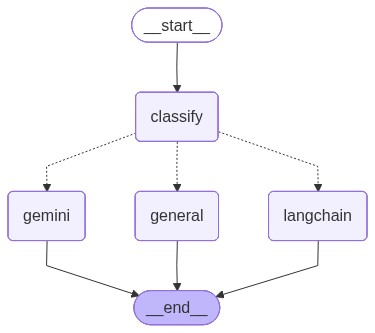

In [8]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [9]:
for step in chain.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

RecursionError: maximum recursion depth exceeded

## Next steps

You've now learned how to add routing to your composed LCEL chains.

Next, check out the other how-to guides on runnables in this section.